# Início

In [1]:
print("hello world")

hello world


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

2024-10-22 13:40:30.241655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 13:40:30.540243: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-22 13:40:31.128788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 13:40:31.147465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 13:40:31.150671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Definindo diretório de imagens
Definindo o diretório que contém as pastas contendo as imagens categorizada.

In [4]:
# Mapear arquivos ocultos (.ipny)
# A ser utilizada caso não tenha o .ipynb_checkpoints
def filter_hidden_folders(folder_list):
    return [folder for folder in folder_list if not folder.startswith('.')]

In [5]:
# Caminho para os dados do dataset e o reescalador de imagens
xray_directory  = 'font_results/cropped'

xray_classes = os.listdir(xray_directory)
print(f"Classes: {xray_classes}")

class_count = len(os.listdir(xray_directory))
print(f"Quantidade de classes:{class_count} => 26 letras maiúsculas + 26 minúsculas + 1 nula")

Classes: ['g', 'V', 'W', 'r', 'i', 'a', 'G', 'I', 's', 'J', 'y', 'z', 't', 'c', 'Q', 'u', 'E', 'o', 'H', 'B', 'U', 'N', 'F', 'm', 'n', 'v', 'T', 'D', 'A', 'e', 'w', 'O', '.ipynb_checkpoints', 'S', 'K', 'l', 'C', 'q', 'p', 'Z', 'j', 'h', 'f', 'L', 'M', 'b', 'd', 'P', 'x', 'X', 'Y', 'R', 'k']
Quantidade de classes:53 => 26 letras maiúsculas + 26 minúsculas + 1 nula


## Criando a rede neural

In [6]:
# Definir parâmetros
INPUT_SHAPE = (100, 120, 1)  # Imagem 120x100, 1 canal (grayscale)

In [7]:
# Carregar o modelo VGG16 pré-treinado com pesos do ImageNet
# Incluir a camada de pooling global (retirar as camadas de classificação final)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 120, 3))

# Adaptar a camada de entrada para grayscale (1 canal)
# Expanda o canal para 3 (de 1 para 3) para o modelo pré-treinado que usa RGB
inputs = layers.Input(shape=INPUT_SHAPE)
model_flow = layers.Conv2D(3, (3, 3), padding='same')(inputs)  # Converter 1 canal para 3

# Conectar o modelo pré-treinado
model_flow = base_model(model_flow)
model_flow = layers.GlobalAveragePooling2D()(model_flow)

# Adicionar as camadas de classificação
model_flow = layers.Dense(512, activation='relu')(model_flow)
model_flow = layers.Dense(class_count, activation='softmax')(model_flow)

# Criar o modelo final
model = models.Model(inputs, model_flow)

# Congelar as camadas do modelo pré-treinado para não treiná-las no início
for layer in base_model.layers:
    layer.trainable = False

2024-10-22 13:40:31.162859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 13:40:31.166040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 13:40:31.167615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 120, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │        27,189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,004,563 (57.24 MB)

 Trainable params: 289,875 (1.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Salvar o arquivo de treinamento em diferentes epocas

# Nome/caminho do arquivo que sera salvo
model_file = "weights_cropped_vgg16.keras" 

# Define os parametros para atualizar o arquivo final
# ModelCheckpoint(nome_do_arquivo, monitor = 'parametro a ser analisado', verbose = 1 (imprimir no console quando arquivo for salvo), save_best_only = True, mode = 'min' (objetivo minimizar perda))
checkpoint = ModelCheckpoint(model_file, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

# Cria uma lista que contém o ModelCheckpoint configurado usado durante o treinamento
callbacks_list = [checkpoint]

## Criando as bases de dados

In [10]:
# Gerenciador de imagem para pre processamento
# Normaliza(rescale) a base de dados
# Divide a base de dados para que parte dela seja usada na validação dos dados. 
# Aumenta a base através de leves alterações como: zoom aleatório <= zoom_range, inversão horizontal aleatória
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.3,
    zoom_range=0.2,
)


In [11]:
BATCH_SIZE = 50
TARGET_SIZE=(100, 120) # ALTURA X LARGURA, é invertido aqui...
CMODE='grayscale'
CLASS_MODE='categorical'
# Imagens para treinamento
train_generator = train_datagen.flow_from_directory(
    xray_directory,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=CMODE, 
    class_mode=CLASS_MODE,
    shuffle=True,
    subset='training'
)

# Imagens para validação
validation_generator = train_datagen.flow_from_directory(
        xray_directory,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        color_mode=CMODE,
        class_mode=CLASS_MODE,
        shuffle=True,
        subset = 'validation'
        )


Found 2658395 images belonging to 53 classes.
Found 1139269 images belonging to 53 classes.


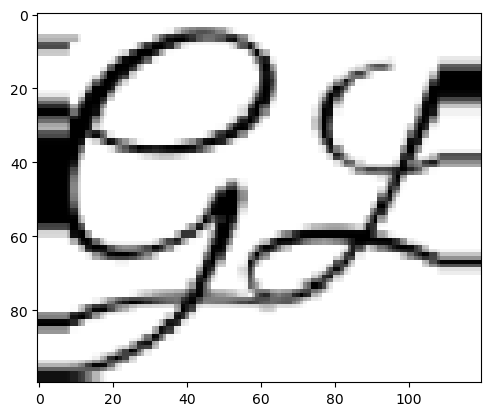

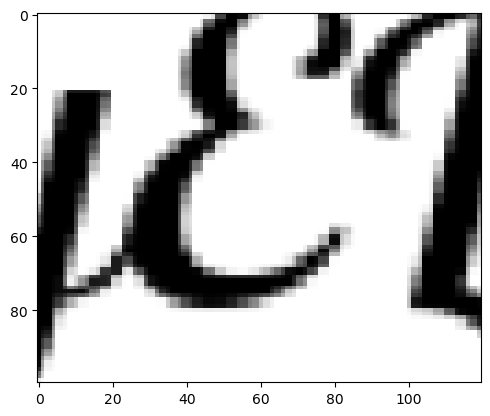

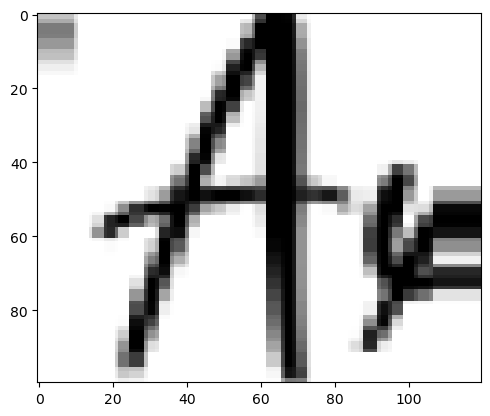

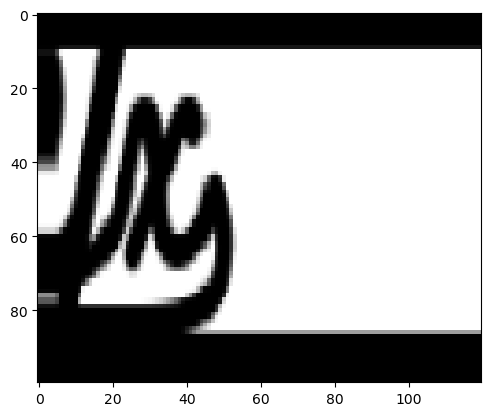

In [12]:
#Visualizando amostra da base de dados de treinamento.
def show_images_in_range(images, RANGE = 2):
    for i in range(0, RANGE):  # Mostra as primeiras 5 imagens
        image = images[i]
        plt.imshow(image, cmap = "gray")
        plt.show()


train_batch, _ = next(train_generator)
show_images_in_range(train_batch)
val_batch, _ = next(validation_generator)
show_images_in_range(val_batch)


In [13]:
# Visualizando formato das imagens no banco e classes
print(train_generator.class_indices)

for data_batch, labels_batch in train_generator:
    print("Imagens: ", data_batch.shape)
    print("Labels: ", labels_batch.shape)
    break  # Apenas testar um batch


{'.ipynb_checkpoints': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52}
Imagens:  (50, 100, 120, 1)
Labels:  (50, 53)


## treinamento do modelo 

steps_per_epoch = len(train_generator) - 1  # Total de batches por época

In [ ]:
history = model.fit(train_generator, epochs = 15, validation_data=validation_generator, callbacks=callbacks_list)
aux = history
history = history.history.keys() #paramestros de avaliação accuracy, loss

## Salvando progresso

In [14]:
hist_df = pd.DataFrame(aux.history)
print(hist_df)

NameError: name 'aux' is not defined

In [15]:
# Salvar o DataFrame em um arquivo CSV
hist_df.to_csv('training_history_cropped_vgg16.csv', index=False)

NameError: name 'hist_df' is not defined

In [16]:
# Carregar os dados do CSV
loaded_history_df = pd.read_csv('training_history_cropped_vgg16.csv')
# Exibir os dados carregados (opcional)
print(loaded_history_df)

    accuracy      loss  val_accuracy  val_loss
0   0.579124  1.489506      0.534339  1.759844
1   0.676156  1.115122      0.573045  1.640009
2   0.697910  1.032596      0.576681  1.676294
3   0.710297  0.988883      0.585907  1.642722
4   0.717895  0.959680      0.590881  1.643022
5   0.723226  0.940888      0.593464  1.634103
6   0.727948  0.925379      0.600973  1.605780
7   0.731392  0.911801      0.606406  1.543429
8   0.734215  0.901385      0.599667  1.639374
9   0.736816  0.892340      0.599804  1.647034
10  0.739161  0.884180      0.607813  1.594575
11  0.740889  0.877111      0.606667  1.608003
12  0.742712  0.871589      0.609393  1.584921
13  0.743925  0.865626      0.612510  1.602747
14  0.745234  0.861255      0.611501  1.591061


## Visualização do progresso do modelo

### Visualização: Linhas de erro, loss, accuracy

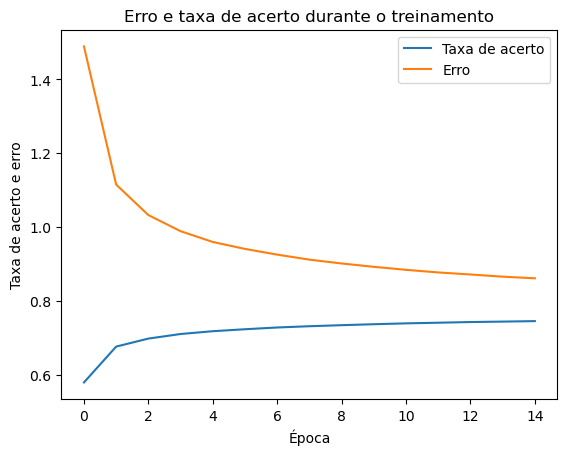

In [17]:
# Exemplo de grafico para ver taxa de acerto por taxa de erro 
plt.plot(loaded_history_df['accuracy'])
plt.plot(loaded_history_df['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);
plt.show()

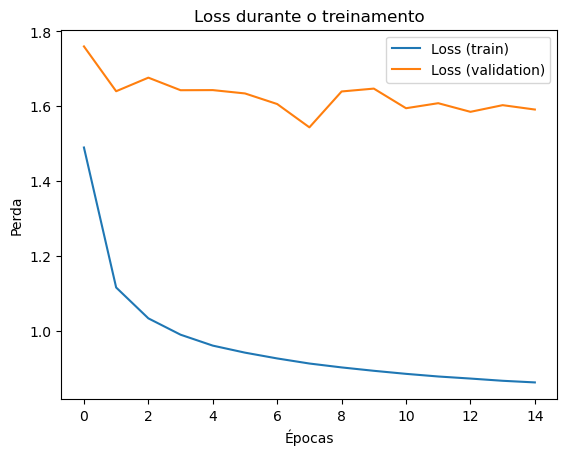

In [18]:
# Plotar a perda de treinamento e validação
plt.plot(loaded_history_df['loss'], label='Loss (train)')
plt.plot(loaded_history_df['val_loss'], label='Loss (validation)')
plt.title('Loss durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

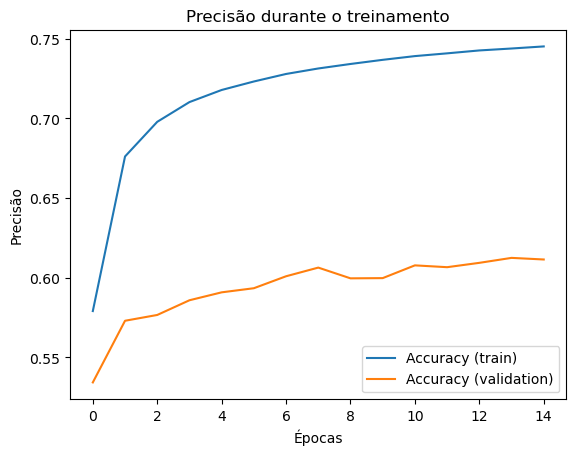

In [19]:

# Plotar a precisão de treinamento e validação
plt.plot(loaded_history_df['accuracy'], label='Accuracy (train)')
plt.plot(loaded_history_df['val_accuracy'], label='Accuracy (validation)')
plt.title('Precisão durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()
plt.show()

### Definindo funções de visualização

In [30]:
#Comparação de Loss e Accuracy de redes distintas
def plot_comparison(results, metric='accuracy'):
    models = list(results.keys())
    final_accuracy = [results[model][metric][-1] for model in models]
    
    plt.figure(figsize=(10, 5))
    plt.bar(models, final_accuracy)
    plt.title(f'Comparação de {metric} entre diferentes redes')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Modelos')
    plt.show()

In [31]:
#Grafico de curvas para comparação entre redes
def plot_comparison_curves(results, metric='accuracy'):
    plt.figure(figsize=(10, 5))
    
    for model, history in results.items():
        plt.plot(history[metric], label=f'{model} - train')
        plt.plot(history['val_' + metric], '--', label=f'{model} - val')
    
    plt.title(f'Comparação de {metric.capitalize()} entre Redes')
    plt.xlabel('Épocas')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


In [32]:
#Matriz Confusão

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()

In [33]:
#Boxplot
def plot_boxplot(results, metric='accuracy'):
    data = [history[metric] for history in results.values()]
    labels = results.keys()

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.title(f'Boxplot de {metric.capitalize()} entre Redes')
    plt.ylabel(metric.capitalize())
    plt.show()

### Funções auxiliares e variáveis

In [46]:
def dataframe_to_dict(dataframe):
    return {
        'accuracy': dataframe['accuracy'].tolist(),
        'loss': dataframe['loss'].tolist()
    }

In [47]:
history1 = pd.read_csv('training_history_cropped_vgg16.csv')
history2 = pd.read_csv('training_history_cropped_original.csv')
history_dict = {
    'Cropped VGG16': dataframe_to_dict(history1),
    'Cropped Original': dataframe_to_dict(history2),
}

In [48]:
loaded_model = load_model('weights_cropped_vgg16.keras')

In [49]:
# define caminho para pasta de teste
test_directory = "test_images/cropped"
# lista contendo os nomes dos arquivos e diretórios presentes no caminho fornecido
os.listdir(test_directory)

['g',
 'V',
 'W',
 'r',
 'i',
 'a',
 'G',
 'I',
 's',
 'J',
 'y',
 'z',
 't',
 'c',
 'Q',
 'u',
 'E',
 'o',
 'H',
 'B',
 'U',
 'N',
 'F',
 'm',
 'n',
 'v',
 'T',
 'D',
 'A',
 'e',
 'w',
 'O',
 '.ipynb_checkpoints',
 'S',
 'K',
 'l',
 'C',
 'q',
 'p',
 'Z',
 'j',
 'h',
 'f',
 'L',
 'M',
 'b',
 'd',
 'P',
 'x',
 'X',
 'Y',
 'R',
 'k']

In [52]:
# Mudar a escala das imagens
test_gen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.3,
    zoom_range=0.2,
)

test_generator = test_gen.flow_from_directory(
    batch_size = 13, 
    directory = test_directory, 
    target_size = TARGET_SIZE,
    color_mode='grayscale',  # Converte as imagens para 1 canal
    class_mode = 'categorical'
)

evaluate = loaded_model.evaluate(test_generator)
print(evaluate)

Found 108 images belonging to 53 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7870 - loss: 0.7863 
[0.7450742125511169, 0.7962962985038757]


## Chamando as funções de visualização

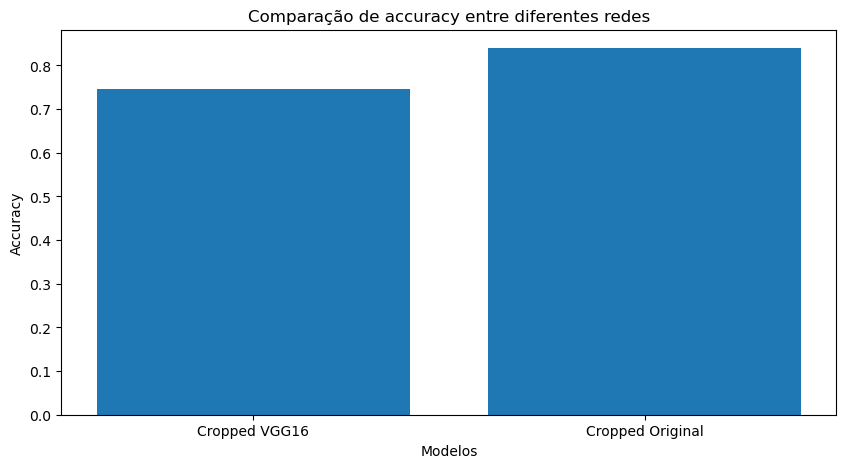

In [53]:
plot_comparison(history_dict, metric='accuracy')

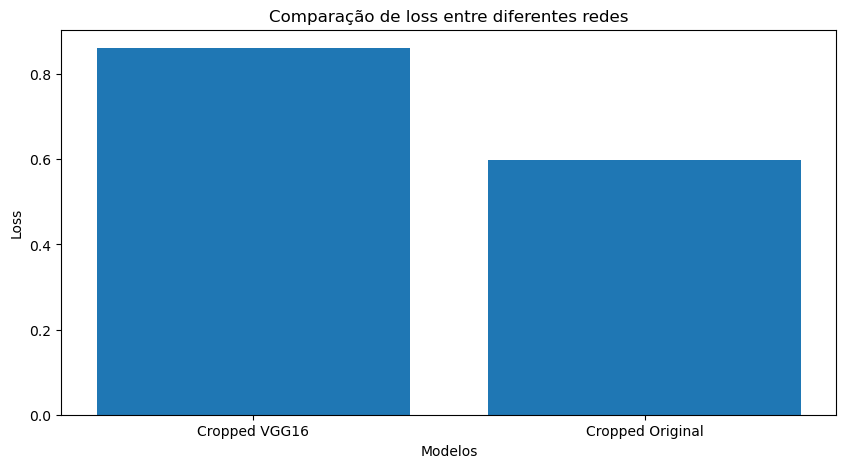

In [54]:
plot_comparison(history_dict, metric='loss')

In [58]:
# aplica a rede treinada em um conjunto de teste de imagens e armazena os resultados
prediction = []
original = []
image = []

# percorre as subpastas no diretório test_directory, assumindo que cada subpasta contém imagens de uma determinada classe
for i in os.listdir(test_directory):
  # percorre os arquivos dentro de cada subpasta e processa cada imagem
  for item in os.listdir(os.path.join(test_directory, i)):
    
    #Etapas de processamento de img

    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (100, 120))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 100, 120, 1)

    #rede neural aplicada
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

2024-10-22 14:43:17.413449: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-22 14:43:17.443169: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━

In [59]:
accuracy_score(original, prediction)

0.0

NameError: name 'labels_names' is not defined

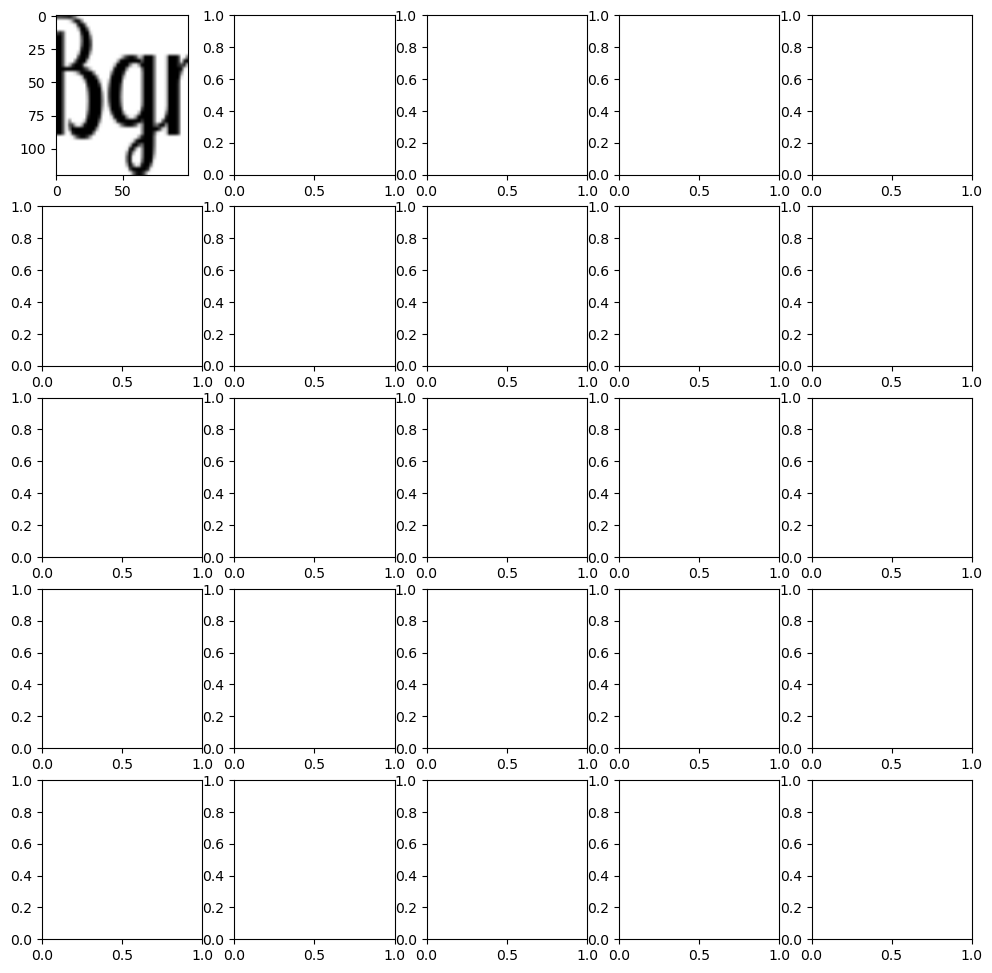

In [60]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [67]:
model_load = load_model('weights_cropped_vgg16.keras')
image = Image.open("/home/picg/TCC/GeradorBase/font_results/cropped/a/a-lal-GrandHotel-Regular.png")
image_grayscale = image.convert('L')
image_array = np.array(image_grayscale)
image_input_resized = cv2.resize(image_array, (100, 120))
print(image_input_resized.shape)
image_array_normalized = image_input_resized / 255.0

# Adicionar uma dimensão para corresponder ao formato de entrada esperado pelo modelo
final_image = image_array_normalized.reshape(1, 100, 120, 1)  # '1' aqui é o batch size

prediction = model_load.predict(final_image)
print("Predição:", prediction)


(120, 100)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predição: [[2.21763814e-19 3.72883086e-10 1.58998589e-07 1.50863730e-06
  6.12516927e-13 1.27436260e-05 7.51854395e-12 3.85405293e-12
  5.40582512e-09 1.57561596e-03 5.80202102e-11 1.61478768e-14
  2.55886139e-08 2.09488117e-19 6.29290188e-20 1.30461365e-06
  1.63044871e-13 2.34885089e-08 1.29407015e-11 1.07023453e-07
  8.00305244e-08 8.47822593e-12 1.57401989e-12 8.49577769e-11
  1.25882620e-11 2.67575909e-18 1.49721572e-11 2.84556542e-02
  5.13273608e-06 4.63123620e-02 5.89784622e-06 2.11240739e-01
  2.19948910e-13 4.57759626e-08 2.82208666e-11 9.33569819e-02
  3.27400426e-06 2.76678360e-08 1.19311125e-07 2.02750471e-06
  2.35504750e-03 1.14912260e-02 2.75376788e-05 4.73183627e-06
  2.35039636e-01 2.08178462e-04 3.14922158e-06 1.71397179e-01
  1.29961921e-02 1.82506084e-01 2.98177311e-03 2.25980855e-07
  1.51756458e-05]]


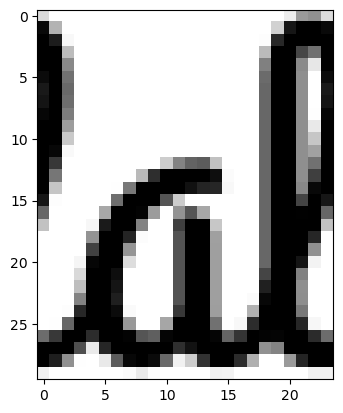

In [68]:
plt.imshow(image_grayscale, cmap="gray")

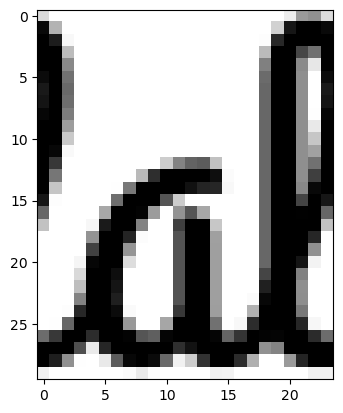

In [69]:
#image = np.array(Image.open("/home/picg/TCC/GeradorBase/font_results/normal/a/a-mam-GrandHotel-Regular.png"))
plt.imshow(image, cmap="gray")

In [70]:

# Achar a classe com maior probabilidade
predicted_class = np.argmax(prediction)

# Definir labels (saidas) 
labels_names = {0: '.ipynb_checkpoints', 1: 'a',2: 'A',3: 'b',4: 'B',5: 'c',6: 'C',7: 'd',8: 'D',9: 'e',10: 'E', 11: 'f',12: 'F',13: 'g',14: 'G',15: 'h',16: 'H',17: 'i',18: 'I',19: 'j',20: 'J', 21: 'k',22: 'K',23: 'l',24: 'L',25: 'm',26: 'M',27: 'n',28: 'N',29: 'o',30: 'O', 31: 'p',32: 'P',33: 'q',34: 'Q',35: 'r',36: 'R',37: 's',38: 'S',39: 't',40: 'T', 41: 'u',42: 'U',43: 'v',44: 'V',45: 'w',46: 'W',47: 'x',48: 'X',49: 'y',50: 'Y', 51: 'z',52: 'Z',
                }

print(f"A classe prevista é - {predicted_class}: {labels_names[predicted_class]}")


A classe prevista é - 44: V


In [71]:
model_load.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 120, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │        27,189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,584,315 (59.45 MB)

 Trainable params: 289,875 (1.11 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 579,752 (2.21 MB)

#### Todas as classes:
'''
{'.ipynb_checkpoints': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, 'a': 27, 'b': 28, 'c': 29, 'd': 30, 'e': 31, 'f': 32, 'g': 33, 'h': 34, 'i': 35, 'j': 36, 'k': 37, 'l': 38, 'm': 39, 'n': 40, 'o': 41, 'p': 42, 'q': 43, 'r': 44, 's': 45, 't': 46, 'u': 47, 'v': 48, 'w': 49, 'x': 50, 'y': 51, 'z': 52}
'''
